<a href="https://colab.research.google.com/github/wayneleehan/AI-learning/blob/main/hmm%E9%A0%90%E6%B8%AC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install backtrader
import pandas as pd
import numpy as np
import backtrader as bt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 419.5/419.5 kB 7.8 MB/s eta 0:00:00


In [ ]:
df = pd.read_csv("2603_stock_price.csv", parse_dates=['年月日'], encoding='big5')

In [ ]:
df #確認一下資料

,證券代碼,年月日,開盤價(元),最高價(元),最低價(元),收盤價(元),成交量(千股),成交值(千元),報酬率％,週轉率％,...,現金股利率,股價漲跌(元),高低價差%,次日開盤參考價,次日漲停價,次日跌停價,注意股票(A),處置股票(D),全額交割(Y),市場別
0,2603,2008-01-02,29.30,30.15,28.80,28.80,25057.290,7.424344e+05,-2.7027,0.8259,...,1.0000,-0.80,4.5608,28.80,30.80,26.80,NaN,NaN,NaN,TSE
1,2603,2008-01-03,27.80,30.20,27.80,29.60,23630.167,6.913757e+05,2.7778,0.7789,...,0.9800,0.80,8.3333,29.60,31.65,27.55,NaN,NaN,NaN,TSE
2,2603,2008-01-04,30.00,30.45,29.20,30.35,32615.551,9.751622e+05,2.5338,1.0750,...,0.9500,0.75,4.2230,30.35,32.45,28.25,NaN,NaN,NaN,TSE
3,2603,2008-01-07,29.60,29.80,28.55,28.55,27033.081,7.900244e+05,-5.9308,0.8910,...,1.0100,-1.80,4.1186,28.55,30.50,26.60,NaN,NaN,NaN,TSE
4,2603,2008-01-08,28.55,30.50,28.55,30.50,38955.949,1.175773e+06,6.8301,1.2840,...,0.9500,1.95,6.8301,30.50,32.60,28.40,NaN,NaN,NaN,TSE
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4034,2603,2024-05-29,222.50,227.50,217.00,218.00,52561.833,1.168251e+07,-0.2288,2.4444,...,4.5736,-0.50,4.8055,218.00,239.50,196.50,NaN,NaN,NaN,TSE
4035,2603,2024-05-30,219.00,221.00,215.00,218.50,29442.445,6.419678e+06,0.2294,1.3692,...,4.5632,0.50,2.7523,218.50,240.00,197.00,NaN,NaN,NaN,TSE
4036,2603,2024-05-31,221.00,226.00,210.00,210.50,71240.361,1.546429e+07,-3.6613,3.3131,...,4.7366,-8.00,7.3227,210.50,231.50,189.50,NaN,NaN,NaN,TSE
4037,2603,2024-06-03,216.50,218.00,211.00,215.50,36534.715,7.849794e+06,2.3753,1.6991,...,4.6267,5.00,3.3254,215.50,237.00,194.00,NaN,NaN,NaN,TSE


In [ ]:
df.rename(columns={
    '年月日': 'Date',
    '開盤價(元)': 'Open',
    '最高價(元)': 'High',
    '最低價(元)': 'Low',
    '收盤價(元)': 'Close',
    '成交量(千股)': 'Volume',
    '股價漲跌(元)': 'Increase'
}, inplace=True)
df.set_index('Date', inplace=True)

In [ ]:
df.index = pd.to_datetime(df.index)

In [ ]:
df['avg5dIncrease'] = df['Increase'].rolling(window=5).mean()

In [ ]:
df['label'] = df['avg5dIncrease'].apply(
    lambda x: 'strong' if x > 0 else ('weak' if x < 0 else 'normal')
)

In [ ]:
print(df[['avg5dIncrease', 'label']])

            avg5dIncrease   label
Date                             
2008-01-02            NaN  normal
2008-01-03            NaN  normal
2008-01-04            NaN  normal
2008-01-07            NaN  normal
2008-01-08           0.18  strong
...                   ...     ...
2024-05-29           1.80  strong
2024-05-30           1.90  strong
2024-05-31          -1.80    weak
2024-06-03          -1.50    weak
2024-06-04          -1.50    weak

[4039 rows x 2 columns]


In [ ]:
df.to_csv("2603_stock_price_label.csv")

In [ ]:
from collections import Counter

labels = df['label'].dropna().tolist()
transitions = list(zip(labels[:-1], labels[1:]))

# 重新分類後的有效轉移
mapped_transitions = []

for a, b in transitions:
    if a == 'weak' and (b == 'normal' or b == 'strong'):
        mapped_transitions.append(('weak', 'strong'))  # W→S
    elif a == 'normal' and b == 'strong':
        mapped_transitions.append(('weak', 'strong'))  # W→S
    elif a == 'strong' and (b == 'normal' or b == 'weak'):
        mapped_transitions.append(('strong', 'weak'))  # S→W
    elif a == 'normal' and b == 'weak':
        mapped_transitions.append(('strong', 'weak'))  # S→W
    else:
        # same state (e.g. W→W or S→S)
        mapped_transitions.append((a, b))

# 統計新的 2x2 轉移次數
count = Counter(mapped_transitions)

total_from = {
    'strong': count[('strong', 'strong')] + count[('strong', 'weak')],
    'weak': count[('weak', 'strong')] + count[('weak', 'weak')],
}

P_SS = count[('strong', 'strong')] / total_from['strong']
P_SW = count[('strong', 'weak')] / total_from['strong']
P_WS = count[('weak', 'strong')] / total_from['weak']
P_WW = count[('weak', 'weak')] / total_from['weak']

T = pd.DataFrame([
    [P_SS, P_SW],
    [P_WS, P_WW]
], index=['strong', 'weak'], columns=['strong', 'weak'])

print("轉換矩陣：")
print(T)

轉換矩陣：
          strong      weak
strong  0.787792  0.212208
weak    0.226991  0.773009


In [ ]:
cash = 100000
stock = 0.0
amount = 1000

In [ ]:
df['action'] = None
df['year'] = pd.to_datetime(df.index).year  # 加入年份欄位
df['portfolio'] = 0.0  # 每日資產紀錄

labels = df['label'].tolist()
years = sorted(df['year'].unique())

annual_returns = {}
year_start_value = cash

In [ ]:
for i in range(1, len(df)):
    prev = labels[i - 1]
    curr = labels[i]
    price = df.iloc[i]['Close']
    date = df.index[i]
    year = df.iloc[i]['year']

    # weak轉strong買入
    if prev == 'weak' and curr == 'strong' and cash >= amount:
        shares = amount / price
        stock += shares
        cash -= amount
        df.iat[i, df.columns.get_loc('action')] = 'buy'

    # strong轉weak賣出
    elif prev == 'strong' and curr == 'weak' and stock > 0:
        cash += stock * price
        stock = 0
        df.iat[i, df.columns.get_loc('action')] = 'sell'

    # 每天記錄總資產（現金 + 持股）
    total_value = cash + stock * price
    df.iat[i, df.columns.get_loc('portfolio')] = total_value

    # 如果是這一年的最後一筆資料 → 結算報酬
    is_last_of_year = (i < len(df)-1 and df.iloc[i+1]['year'] != year) or (i == len(df)-1)
    if is_last_of_year:
        annual_return = (total_value / year_start_value) - 1
        annual_returns[year] = annual_return
        year_start_value = total_value  # 更新下一年初始資產

In [ ]:
print("每年報酬率 (%):")
for y, r in annual_returns.items():
    print(f"{y}: {r * 100:.2f} %")

print(f"最終資產總值：{total_value:.2f} 元")
print(f"累積報酬率：{(total_value / 100000 - 1) * 100:.2f} %")

每年報酬率 (%):
2008: -0.49 %
2009: 0.08 %
2010: 0.27 %
2011: -0.55 %
2012: 0.22 %
2013: -0.12 %
2014: -0.08 %
2015: -0.03 %
2016: 0.06 %
2017: 0.35 %
2018: -0.15 %
2019: 0.01 %
2020: 1.45 %
2021: 2.04 %
2022: 0.52 %
2023: 0.54 %
2024: 0.02 %
最終資產總值：104185.23 元
累積報酬率：4.19 %


In [ ]:
print(df['action'])

Date
2008-01-02    None
2008-01-03    None
2008-01-04    None
2008-01-07    None
2008-01-08    None
              ... 
2024-05-29    None
2024-05-30    None
2024-05-31    sell
2024-06-03    None
2024-06-04    None
Name: action, Length: 4039, dtype: object


In [ ]:
df.to_csv("2603_stock_price_action.csv")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 165.9/165.9 kB 4.0 MB/s eta 0:00:00


https://github.com/hmmlearn/hmmlearn/issues/335
https://github.com/hmmlearn/hmmlearn/issues/340
<ipython-input-17-28fa09f78550>:43: UserWarning: Glyph 38577 (\N{CJK UNIFIED IDEOGRAPH-96B1}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-17-28fa09f78550>:43: UserWarning: Glyph 34255 (\N{CJK UNIFIED IDEOGRAPH-85CF}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-17-28fa09f78550>:43: UserWarning: Glyph 29376 (\N{CJK UNIFIED IDEOGRAPH-72C0}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-17-28fa09f78550>:43: UserWarning: Glyph 24907 (\N{CJK UNIFIED IDEOGRAPH-614B}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-17-28fa09f78550>:43: UserWarning: Glyph 24207 (\N{CJK UNIFIED IDEOGRAPH-5E8F}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-17-28fa09f78550>:43: UserWarning: Glyph 21015 (\N{CJK UNIFIED IDEOGRAPH-5217}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local

每個隱藏狀態的出現比例：
state 0    0.999752
state 1    0.000248
Name: proportion, dtype: float64

隱藏狀態的轉移機率矩陣：
            to 0      to 1
from 0  0.878274  0.121726
from 1  0.998874  0.001126

隱藏狀態的發射機率（觀測值 0 / 1）：
Shape of emissionprob_: (2, 1)
         obs=0
state 0    1.0
state 1    1.0


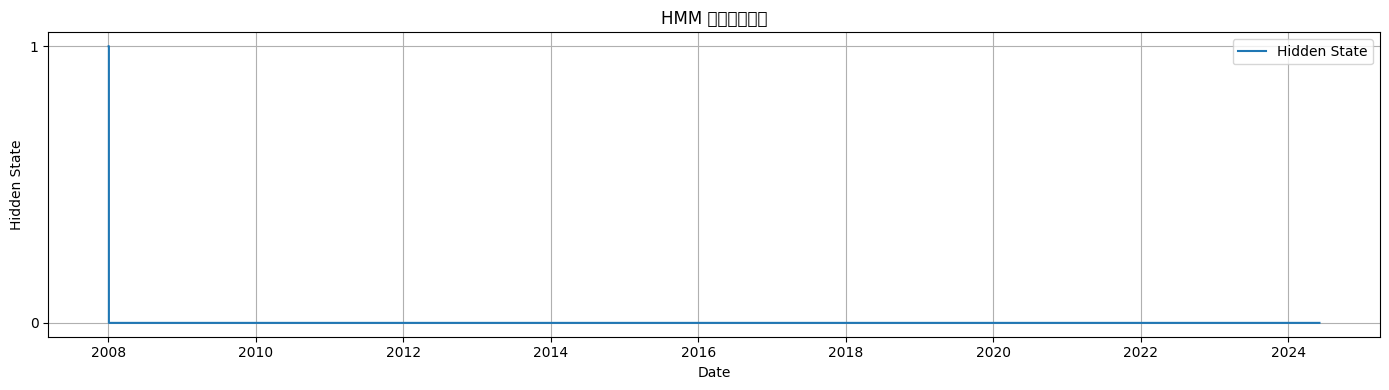

In [ ]:
!pip install hmmlearn
from hmmlearn import hmm
import matplotlib.pyplot as plt

df['obs'] = df['Increase'].apply(lambda x: 1 if x > 0 else 0)
df_obs = df.dropna(subset=['obs'])
obs_seq = df_obs['obs'].astype(int).values.reshape(-1, 1)

# HMM 模型
model = hmm.MultinomialHMM(n_components=2, random_state=42, n_iter=100)
model.fit(obs_seq)

# 預測隱藏狀態
hidden_states = model.predict(obs_seq)

# 加回原本的df中
df.loc[df_obs.index, 'hmm_state'] = hidden_states

# 顯示狀態比例與轉移矩陣
print("每個隱藏狀態的出現比例：")
print(pd.Series(hidden_states).value_counts(normalize=True).sort_index().rename({0: 'state 0', 1: 'state 1'}))

print("\n隱藏狀態的轉移機率矩陣：")
print(pd.DataFrame(model.transmat_, columns=['to 0', 'to 1'], index=['from 0', 'from 1']))

print("\n隱藏狀態的發射機率（觀測值 0 / 1）：")
print(f"Shape of emissionprob_: {model.emissionprob_.shape}")

if model.emissionprob_.shape[1] == 1:
    print(pd.DataFrame(model.emissionprob_, columns=['obs=0'], index=['state 0', 'state 1']))
else:
    print(pd.DataFrame(model.emissionprob_, columns=['obs=0', 'obs=1'], index=['state 0', 'state 1']))


# 畫出狀態變化時間圖
plt.figure(figsize=(14, 4))
plt.plot(df_obs.index, hidden_states, drawstyle='steps-post', label='Hidden State')
plt.title("HMM 隱藏狀態序列")
plt.xlabel("Date")
plt.ylabel("Hidden State")
plt.yticks([0, 1])
plt.grid(True)
plt.tight_layout()
plt.legend()
plt.show()